# 11. 항공 사진 내 선인장 식별
* 경진대회명
    * 항공 사진 내 선인장 식별 경진대회
* 미션
    * 항공 사진 내 선인장이 있을 확률 예측
* 문제유형
    * 이진분류
* 평가지표
    * ROC AUC
## 11.1 경진대회 이해
* 드론이 멕시코의 보호지역을 돌아다니며 찍은 항공 사진에서 선인장(cactus)을 찾아내는게 목표
* 데이터
    * train.zip : 훈련 이미지 데이터 압축 파일
    * test.zip : 테스트 이미지 데이터 압축 파일
    * train.csv : 훈련 이미지 데이터 파일명 및 타깃값(0 or 1)
    * sample_submission.csv : 샘플 제출 파일

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## 11.2 탐색적 데이터 분석

In [2]:
data_path = '../../data/11_cactus/'
labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')

### 11.2.1 데이터 둘러보기

In [3]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [7]:
labels.has_cactus.mean()

0.7506285714285714

### 11.2.2 데이터 시각화

([<matplotlib.patches.Wedge at 0x1bf97da97e0>,
 [Text(-0.7793519565739233, 0.7762799287527649, 'Has catus'),
  Text(0.7793519929142084, -0.776279892268666, "Hasn't catus")],
 [Text(-0.4251010672221399, 0.42342541568332626, '75.1'),
  Text(0.42510108704411365, -0.42342539578290866, '24.9')])

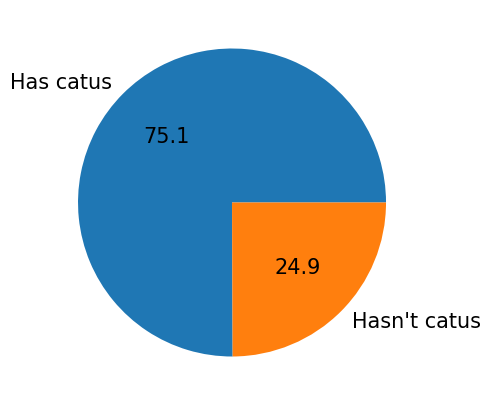

In [9]:
# 타깃값 분포
mpl.rc('font', size=15)
plt.figure(figsize=(5,5))
label = ['Has catus', 'Hasn\'t catus']
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f')

In [16]:
# 압축 풀기
from zipfile import ZipFile

with ZipFile(data_path+'train.zip') as zipper:
    zipper.extractall(data_path)
with ZipFile(data_path+'test.zip') as zipper:
    zipper.extractall(data_path)

In [18]:
import os
num_train = len(os.listdir(data_path+'train/'))
num_test = len(os.listdir(data_path+'test/'))
print(f'train data : {num_train}, test data : {num_test}')

train data : 17500, test data : 4000


(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


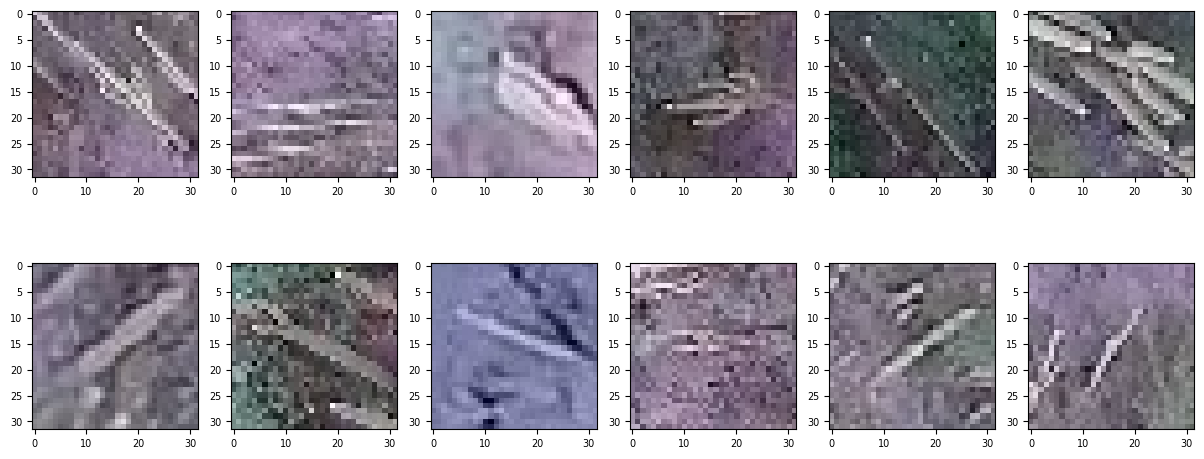

In [22]:
# 선인장이 있는 사진 출력
# pip install opencv-python
import matplotlib.gridspec as gridspec
import cv2

mpl.rc('font', size=7)
plt.figure(figsize=(15,6))
grid = gridspec.GridSpec(1,6)
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-6:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = data_path+'train/'+img_name
    image = cv2.imread(img_path) # BGR
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)


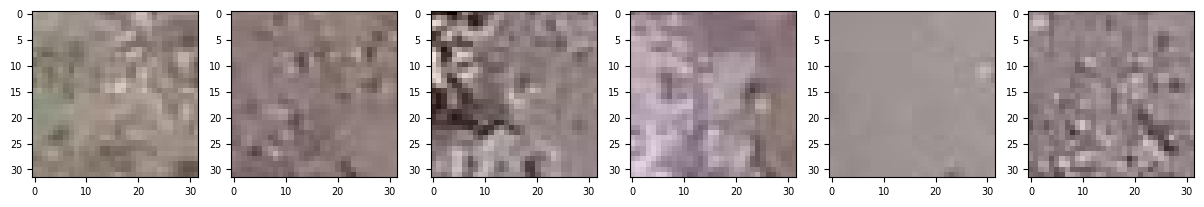

In [24]:
# 선인장이 없는 사진 출력
mpl.rc('font', size=7)
plt.figure(figsize=(15,6))
grid = gridspec.GridSpec(1,6)
last_has_cactus_img_name = labels[labels['has_cactus']==0]['id'][-6:]

for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = data_path+'train/'+img_name
    image = cv2.imread(img_path) # BGR
    print(image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(grid[idx])
    ax.imshow(image)

### 분석 정리 및 모델링 전략
* 분석 정리
    * csv 파일의 id피처는 이미지 파일명
    * 낮은 해상도의 컬러 이미지(32 x 32 x 3)
* 모델링 전략
    * 베인스라인 모델 : 얕은 CNN
        * 신경망 구조 : 합성곱 x 2, 풀링, 평탄화, 전결합
        * 옵티마이저 : SGD
    * 성능 개선 : 살짝 깊은 CNN
        * 데이터 증강 : 다양한 변환기 사용
        * 신경망 구조 : 합성곱 x 5, 배치 정규화, 풀링, 평탄화, 전결합 x 2
        * 옵티마이저 : Adamax
        * 기타 : 훈련 에폭 수 증가